In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

from Supervised_Autoencoder_SAE import sae
import tensorflow as tf
from keras import models
import keras
import os
import warnings

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning, module="keras")

name_df = 'df_completo_filtrato_tesi'
result_path = os.path.join('./results', name_df)
result_path = os.path.join(result_path, 'multiclass')
result_path = os.path.join(result_path, 'without_metadata')

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
np.random.seed(0)
tf.random.set_seed(800)
keras.utils.set_random_seed(800)

In [2]:
df = pd.read_csv(f'data/{name_df}.csv', encoding='utf-8')
df

,SampleID,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,...,Study,Country,Age,Gender,BMI,Total_reads,Reads_after_QC,used_read_count_percentage,16S_Region,Seq_platform
0,ERR475500,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,...,Zeller,FRA,58,M,24,760950,463747,60.94,V4,Illumina MiSeq
1,Cancer7-2537,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,...,Zackular,USA,74,f,32,542053,381315,70.35,V4,Illumina MiSeq
2,ERR475501,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,...,Zeller,FRA,63,M,22,637951,410753,64.39,V4,Illumina MiSeq
3,ERR475507,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,...,Zeller,FRA,71,F,22,891454,490081,54.98,V4,Illumina MiSeq
4,ERR475506,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,...,Zeller,FRA,53,F,33,708115,472251,66.69,V4,Illumina MiSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,SRR2143774,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,...,Baxter,USA,63,f,25,9913,6828,68.88,V4,Illumina MiSeq
704,SRR2143541,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,...,Baxter,USA,59,m,26,7757,4759,61.35,V4,Illumina MiSeq
705,SRR2143550,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,...,Baxter,USA,53,m,29,5838,4046,69.30,V4,Illumina MiSeq
706,SRR2143990,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,...,Baxter,USA,76,f,23,14010,11010,78.59,V4,Illumina MiSeq


# Preprocessing of the dataset deleting unusefull information

Deleting ID and unique value that are irrelevant, we delete also the metadata (AGE, BMI, GENDER)

In [3]:
df.drop(['Age','BMI', 'Gender'], axis=1, inplace=True)
df

,SampleID,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,...,Propionibacterium,SubjectID,Diagnosis,Study,Country,Total_reads,Reads_after_QC,used_read_count_percentage,16S_Region,Seq_platform
0,ERR475500,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,...,-1.030177,CCIS45011002ST,Cancer,Zeller,FRA,760950,463747,60.94,V4,Illumina MiSeq
1,Cancer7-2537,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,...,-0.586193,Cancer7-2537,Cancer,Zackular,USA,542053,381315,70.35,V4,Illumina MiSeq
2,ERR475501,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,...,-0.632061,CCIS15852552ST,Cancer,Zeller,FRA,637951,410753,64.39,V4,Illumina MiSeq
3,ERR475507,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,...,-1.191359,CCIS70195245ST,Large adenoma,Zeller,FRA,891454,490081,54.98,V4,Illumina MiSeq
4,ERR475506,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,...,-0.766400,CCIS32078890ST,Small adenoma,Zeller,FRA,708115,472251,66.69,V4,Illumina MiSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,SRR2143774,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,...,-0.189901,2725650,Adenoma,Baxter,USA,9913,6828,68.88,V4,Illumina MiSeq
704,SRR2143541,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,...,-0.213003,2057650,Normal,Baxter,USA,7757,4759,61.35,V4,Illumina MiSeq
705,SRR2143550,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,...,-0.147902,2075650,Adenoma,Baxter,USA,5838,4046,69.30,V4,Illumina MiSeq
706,SRR2143990,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,...,-0.323407,3279650,Adenoma,Baxter,USA,14010,11010,78.59,V4,Illumina MiSeq


In [4]:
df.drop(['SampleID','SubjectID'], axis=1, inplace=True)
df

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Jonquetella,Propionibacterium,Diagnosis,Study,Country,Total_reads,Reads_after_QC,used_read_count_percentage,16S_Region,Seq_platform
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,Cancer,Zeller,FRA,760950,463747,60.94,V4,Illumina MiSeq
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,Cancer,Zackular,USA,542053,381315,70.35,V4,Illumina MiSeq
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,Cancer,Zeller,FRA,637951,410753,64.39,V4,Illumina MiSeq
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,Large adenoma,Zeller,FRA,891454,490081,54.98,V4,Illumina MiSeq
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,Small adenoma,Zeller,FRA,708115,472251,66.69,V4,Illumina MiSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,Adenoma,Baxter,USA,9913,6828,68.88,V4,Illumina MiSeq
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,Normal,Baxter,USA,7757,4759,61.35,V4,Illumina MiSeq
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,Adenoma,Baxter,USA,5838,4046,69.30,V4,Illumina MiSeq
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,Adenoma,Baxter,USA,14010,11010,78.59,V4,Illumina MiSeq


In [5]:
df['16S_Region'].unique()

array(['V4'], dtype=object)

In [6]:
df.drop(['16S_Region'], axis=1, inplace=True)
df

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Pantalinema,Jonquetella,Propionibacterium,Diagnosis,Study,Country,Total_reads,Reads_after_QC,used_read_count_percentage,Seq_platform
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,-1.030177,Cancer,Zeller,FRA,760950,463747,60.94,Illumina MiSeq
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,-0.586193,Cancer,Zackular,USA,542053,381315,70.35,Illumina MiSeq
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,-0.632061,Cancer,Zeller,FRA,637951,410753,64.39,Illumina MiSeq
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,-1.191359,Large adenoma,Zeller,FRA,891454,490081,54.98,Illumina MiSeq
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,-0.766400,Small adenoma,Zeller,FRA,708115,472251,66.69,Illumina MiSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,-0.189901,Adenoma,Baxter,USA,9913,6828,68.88,Illumina MiSeq
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,-0.213003,Normal,Baxter,USA,7757,4759,61.35,Illumina MiSeq
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,Adenoma,Baxter,USA,5838,4046,69.30,Illumina MiSeq
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,-0.323407,Adenoma,Baxter,USA,14010,11010,78.59,Illumina MiSeq


In [7]:
df.drop(['Reads_after_QC', 'Total_reads', 'used_read_count_percentage'], axis=1, inplace=True)
df

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Acidibacter,Fimbriiglobus,Papillibacter,Pantalinema,Jonquetella,Propionibacterium,Diagnosis,Study,Country,Seq_platform
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,Cancer,Zeller,FRA,Illumina MiSeq
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,Cancer,Zackular,USA,Illumina MiSeq
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,Cancer,Zeller,FRA,Illumina MiSeq
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,Large adenoma,Zeller,FRA,Illumina MiSeq
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,Small adenoma,Zeller,FRA,Illumina MiSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,Adenoma,Baxter,USA,Illumina MiSeq
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,Normal,Baxter,USA,Illumina MiSeq
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,Adenoma,Baxter,USA,Illumina MiSeq
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,Adenoma,Baxter,USA,Illumina MiSeq


In [8]:
df['Seq_platform'].unique()

array(['Illumina MiSeq'], dtype=object)

In [9]:
df.drop(['Seq_platform'], axis=1, inplace=True)
df

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Hydrogenophaga,Acidibacter,Fimbriiglobus,Papillibacter,Pantalinema,Jonquetella,Propionibacterium,Diagnosis,Study,Country
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,Cancer,Zeller,FRA
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,Cancer,Zackular,USA
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,Cancer,Zeller,FRA
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,Large adenoma,Zeller,FRA
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,Small adenoma,Zeller,FRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,Adenoma,Baxter,USA
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,Normal,Baxter,USA
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,Adenoma,Baxter,USA
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,Adenoma,Baxter,USA


Mapping the different values

In [10]:
df['Study'].unique()

array(['Zeller', 'Zackular', 'Baxter'], dtype=object)

In [11]:
study_dict = {
    'Zeller': 0,
    'Zackular': 1,
    'Baxter': 2
}

df['Study'] = df['Study'].map(study_dict)
df['Study'].unique()

array([0, 1, 2])

In [12]:
df['Country'].unique()

array(['FRA', 'USA', 'CA'], dtype=object)

In [13]:
country_dict = {
    'FRA': 0,
    'USA': 1,
    'CA': 2
}

df['Country'] = df['Country'].map(country_dict)
df['Country'].unique()

array([0, 1, 2])

In [14]:
df.fillna(0, inplace=True)

See the mutual information between the feature target and the other feature

In [15]:
class_dict = {
    'Cancer': 1,
    'Adenoma': 2,
    'Large adenoma': 2,
    'Small adenoma': 2,
    'Normal': 0
}

<Axes: >

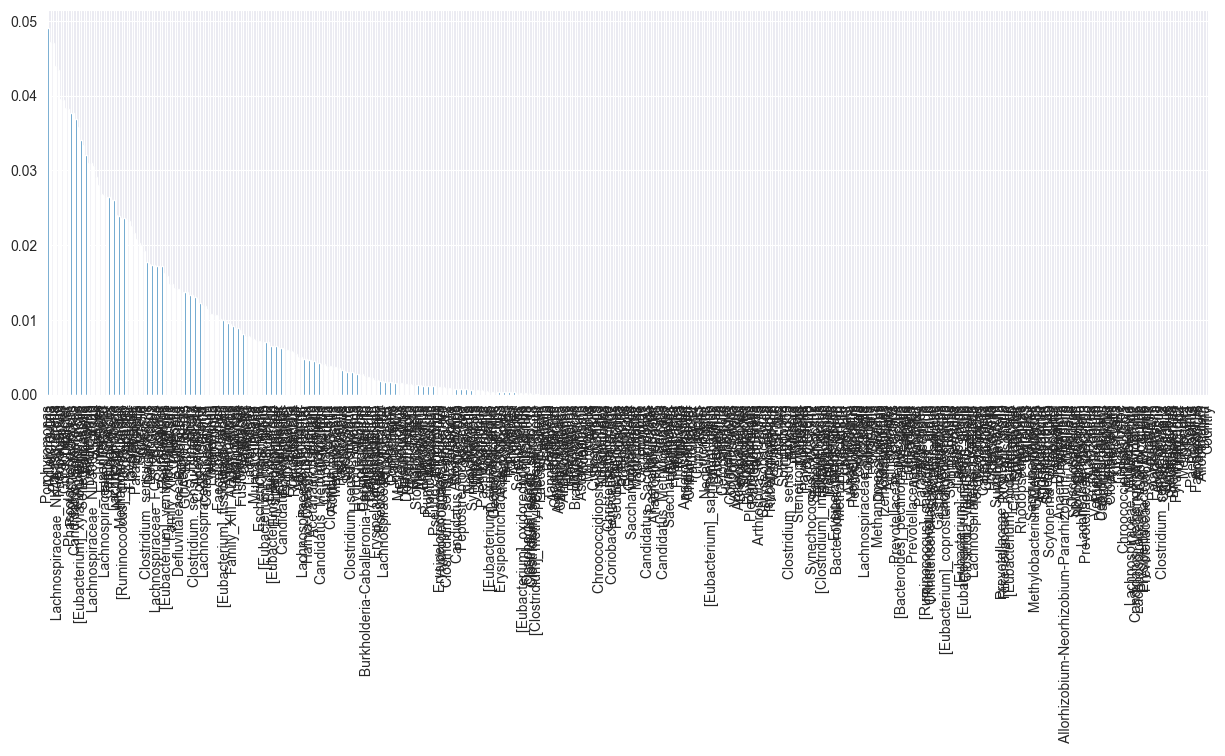

In [16]:
X = df.copy(deep=True)
y = X.pop('Diagnosis')

y = y.map(class_dict)
y = y.fillna(0)

importances = mutual_info_classif(X, y)

mutual_info = pd.Series(importances)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

In [17]:
info = mutual_info * 100
col = list(info[info > 1.5].index)
print('Columns:' + ','.join(col)), len(col)

Columns: Fusobacterium, UCG-002, Methanobrevibacter, Alistipes, CAG-352, [Ruminococcus]_gnavus_group, Desulfovibrio, Porphyromonas, Phascolarctobacterium, NK4A214_group, Dialister, Parvimonas, Clostridium_sensu_stricto_1, Lachnospiraceae_NK4A136_group, Sellimonas, UCG-005, Parasutterella, Odoribacter, Paraprevotella, Flavonifractor, Barnesiella, Turicibacter, Peptostreptococcus, Lactococcus, Eisenbergiella, Sutterella, Frisingicoccus, Anaerotruncus, CAG-56, Deinococcus, Oscillibacter, [Eubacterium]_xylanophilum_group, [Eubacterium]_ventriosum_group, Lachnospiraceae_UCG-010, Lachnospiraceae_ND3007_group, Bilophila, UCG-003, S5-A14a, Peptoniphilus, Senegalimassilia, Lachnospiraceae_FCS020_group, Coprobacter, Campylobacter, Eggerthella, Adlercreutzia, Gordonibacter, Lachnospiraceae, Candidatus_Soleaferrea


(None, 48)

See the distribution of the target data and set X and y

In [18]:
# number of raw
rows = len(df)
rows

708

In [19]:
# Plot the distribution of the label
targ = ['Adenoma', 'Large adenoma', 'Small adenoma']

'Class 2:', len(df[df['Diagnosis'].isin(targ)]), 'Class 1:', len(df[df['Diagnosis'] == 'Cancer']), 'Class 0:', len(df[df['Diagnosis'] == 'Normal'])

('Class 2:', 266, 'Class 1:', 191, 'Class 0:', 251)

## Without Feature selection

In [20]:
X = df.copy(deep=True)
X

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Hydrogenophaga,Acidibacter,Fimbriiglobus,Papillibacter,Pantalinema,Jonquetella,Propionibacterium,Diagnosis,Study,Country
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,Cancer,0,0
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,Cancer,1,1
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,Cancer,0,0
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,Large adenoma,0,0
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,Small adenoma,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,Adenoma,2,1
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,Normal,2,1
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,Adenoma,2,1
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,Adenoma,2,1


In [21]:
y = X.pop('Diagnosis')
y

0             Cancer
1             Cancer
2             Cancer
3      Large adenoma
4      Small adenoma
           ...      
703          Adenoma
704           Normal
705          Adenoma
706          Adenoma
707          Adenoma
Name: Diagnosis, Length: 708, dtype: object

In [22]:
y = y.map(class_dict)
y = y.fillna(0)
y

0      1
1      1
2      1
3      2
4      2
      ..
703    2
704    0
705    2
706    2
707    2
Name: Diagnosis, Length: 708, dtype: int64

In [23]:
n_class = len(y.unique())
n_class

3

In [24]:
X.shape, y.shape, df.shape

((708, 459), (708,), (708, 460))

Configure an unique alpha

In [25]:
# the higher the alpha, the higher is the focus on the reconstruction (loss) 
alpha = .5

In [26]:
percentages = [0, 10, 20, 30, 40]

blinds = [ int((len(df) / 100 * per)/2) for per in percentages]
percentages, blinds

([0, 10, 20, 30, 40], [0, 35, 70, 106, 141])

## With all the dataframe

In [27]:
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
all_mean_results = {key: {
    'macro avg precision': [],
    'macro avg recall': [],
    'macro avg f1-score': [],
    'weighted avg precision': [],
    'weighted avg recall': [],
    'weighted avg f1-score': [],
} for key in percentages }


In [28]:
for fold, (train_index, test_index) in tqdm(enumerate(skf.split(X, y), 1), total=n_splits):
    X_train, X_val = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_val = y[train_index], y[test_index]
        
    index_0 = []
    index_1 = []
    index_2 = []
    blinded = 0
    autoencoder = None
    for percentage, blind in tqdm(zip(percentages, blinds), total=len(percentages)):
        y_train_ssae = y_train.copy(deep=True)
        to_blind = blind - blinded
        
        if percentage != 0:
            index = y_train_ssae[y_train_ssae == 0].index.to_numpy()
            index = [x for x in index if x not in index_0]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_0.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_0)] = None
            
            index = y_train_ssae[y_train_ssae == 1].index.tolist()
            index = [x for x in index if x not in index_1]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_1.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_1)] = None
            
            index = y_train_ssae[y_train_ssae == 2].index.tolist()
            index = [x for x in index if x not in index_2]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_2.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_2)] = None
        
        blinded = blind
        
        autoencoder = sae(
            input_shape=X_train.shape[1], 
            encoder_shape0=32,
            encoder_shape1=16,
            alpha=alpha
        )
        autoencoder.fit(
            X_train, (X_train, y_train_ssae),
            validation_data=(X_val, (X_val, y_val)),
            epochs=200, 
            batch_size=100, 
            verbose=0,
            callbacks=keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                verbose=0,
                restore_best_weights=True,
                mode='min',
            ),
        )
    
        encoder = models.Model(
            inputs=autoencoder.input,
            outputs=autoencoder.get_layer('layer_reduced').output
        )
        
        latent_train = encoder.predict(X_train, verbose=0)
        latent_val = encoder.predict(X_val, verbose=0)
    
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(latent_train, y_train)
        y_pred = rf.predict(latent_val)
    
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        for metric in all_mean_results[percentage].keys():
            if 'macro' in metric:
                all_mean_results[percentage][metric].append(report['macro avg'][metric.split()[-1]])
            elif 'weighted' in metric:
                all_mean_results[percentage][metric].append(report['weighted avg'][metric.split()[-1]])
    
try:
    os.makedirs(result_path)
except:
    pass

result_df = None
for key, metrics in all_mean_results.items():
    mean_results = {metric: round(np.mean(values), 2) for metric, values in metrics.items()}
    
    res = pd.DataFrame([mean_results])
    if key == 0:
        res['Percentage reduction'] = f"SAE - {key}%"
    else:
        res['Percentage reduction'] = f"SSAE - {key}%"
    
    if result_df is None:
        result_df = res
    else:
        result_df = pd.concat([result_df, res], ignore_index=True)

result_df

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,macro avg precision,macro avg recall,macro avg f1-score,weighted avg precision,weighted avg recall,weighted avg f1-score,Percentage reduction
0,0.42,0.41,0.41,0.42,0.42,0.41,SAE - 0%
1,0.38,0.37,0.36,0.38,0.38,0.37,SSAE - 10%
2,0.41,0.40,0.40,0.41,0.42,0.41,SSAE - 20%
3,0.39,0.38,0.38,0.39,0.39,0.38,SSAE - 30%
4,0.40,0.39,0.39,0.40,0.40,0.40,SSAE - 40%


In [29]:
result_path_fs = os.path.join(result_path, 'without_FS')
try:
    os.makedirs(result_path_fs)
except:
    pass

result_df.to_csv(result_path_fs + f'/results_SSAE_alpha={str(alpha)}.csv')

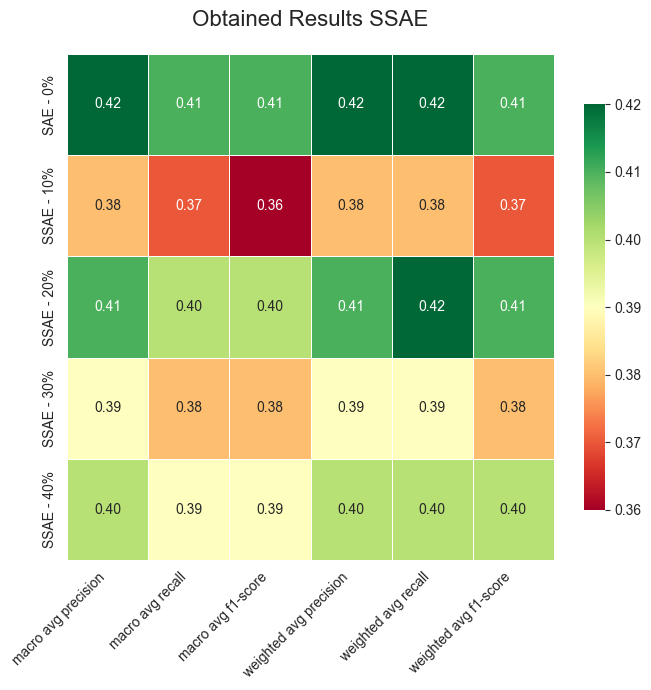

In [30]:
result_path_fs = os.path.join(result_path_fs, "results_heatmap")
try:
    os.makedirs(result_path_fs, exist_ok=True)
except:
    pass
plt.figure(figsize=(7, 7))
sns.heatmap(
    result_df[result_df.columns.values[:-1]],
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    yticklabels=result_df[result_df.columns.values[-1]],
)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

plt.title("Obtained Results SSAE", fontsize=16, pad=20)

plt.tight_layout()
plt.savefig(result_path_fs + f'/results_SSAE_alpha={alpha}.png')
plt.show()

## With Feature selection

In [31]:
X = df.copy(deep=True)
X

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Hydrogenophaga,Acidibacter,Fimbriiglobus,Papillibacter,Pantalinema,Jonquetella,Propionibacterium,Diagnosis,Study,Country
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,Cancer,0,0
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,Cancer,1,1
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,Cancer,0,0
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,Large adenoma,0,0
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,Small adenoma,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,Adenoma,2,1
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,Normal,2,1
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,Adenoma,2,1
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,Adenoma,2,1


In [32]:
y = X.pop('Diagnosis')
y

0             Cancer
1             Cancer
2             Cancer
3      Large adenoma
4      Small adenoma
           ...      
703          Adenoma
704           Normal
705          Adenoma
706          Adenoma
707          Adenoma
Name: Diagnosis, Length: 708, dtype: object

We select the data that are more informative

In [33]:
X = X[col]
X

,Fusobacterium,UCG-002,Methanobrevibacter,Alistipes,CAG-352,[Ruminococcus]_gnavus_group,Desulfovibrio,Porphyromonas,Phascolarctobacterium,NK4A214_group,...,Peptoniphilus,Senegalimassilia,Lachnospiraceae_FCS020_group,Coprobacter,Campylobacter,Eggerthella,Adlercreutzia,Gordonibacter,Lachnospiraceae,Candidatus_Soleaferrea
0,-1.030177,1.965555,7.603435,4.555823,4.629305,2.014346,5.686014,1.049265,6.300228,6.149893,...,-1.030177,-1.030177,-1.030177,2.201944,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177
1,10.592280,-0.586193,1.205566,3.339075,-0.586193,7.112743,-0.586193,1.259633,2.207015,-0.586193,...,1.087783,-0.586193,2.186395,3.182729,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193
2,-0.632061,1.527423,0.667222,6.246265,-0.632061,-0.632061,3.489682,-0.632061,8.361614,-0.632061,...,-0.632061,-0.632061,4.447271,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061
3,-1.191359,6.351914,-1.191359,5.963517,3.771486,-1.191359,5.628294,-1.191359,7.257984,4.229176,...,-1.191359,-1.191359,2.454961,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359
4,-0.766400,4.759053,-0.766400,2.541707,-0.766400,6.301488,-0.766400,-0.766400,-0.766400,5.666004,...,2.026808,-0.766400,3.963933,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,2.449156,-0.189901,-0.189901,1.484075,-0.189901,...,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901
704,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,3.019118,...,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003
705,-0.147902,-0.147902,-0.147902,4.552579,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,2.011582,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902
706,-0.323407,4.421525,4.860248,2.339181,-0.323407,-0.323407,-0.323407,-0.323407,4.510226,4.264956,...,-0.323407,-0.323407,0.880566,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407


In [34]:
y = y.map(class_dict)
y = y.fillna(0)
y

0      1
1      1
2      1
3      2
4      2
      ..
703    2
704    0
705    2
706    2
707    2
Name: Diagnosis, Length: 708, dtype: int64

In [35]:
X.shape, y.shape, df.shape

((708, 48), (708,), (708, 460))

Configure an unique alpha

## With all the dataframe

In [36]:
all_mean_results = {key: {
    'macro avg precision': [],
    'macro avg recall': [],
    'macro avg f1-score': [],
    'weighted avg precision': [],
    'weighted avg recall': [],
    'weighted avg f1-score': [],
} for key in percentages }

In [37]:
for fold, (train_index, test_index) in tqdm(enumerate(skf.split(X, y), 1), total=n_splits):
    X_train, X_val = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_val = y[train_index], y[test_index]
        
    index_0 = []
    index_1 = []
    index_2 = []
    blinded = 0
    for percentage, blind in tqdm(zip(percentages, blinds), total=len(percentages)):
        y_train_ssae = y_train.copy(deep=True)
        to_blind = blind - blinded
        autoencoder = None
        if percentage != 0:
            index = y_train_ssae[y_train_ssae == 0].index.to_numpy()
            index = [x for x in index if x not in index_0]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_0.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_0)] = None
            
            index = y_train_ssae[y_train_ssae == 1].index.tolist()
            index = [x for x in index if x not in index_1]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_1.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_1)] = None
            
            index = y_train_ssae[y_train_ssae == 2].index.tolist()
            index = [x for x in index if x not in index_2]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_2.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_2)] = None
            
        blinded = blind
        
        autoencoder = sae(
            input_shape=X_train.shape[1], 
            encoder_shape0=32,
            encoder_shape1=16,
            alpha=alpha
        )
        autoencoder.fit(
            X_train, (X_train, y_train_ssae),
            validation_data=(X_val, (X_val, y_val)),
            epochs=200, 
            batch_size=100, 
            verbose=0,
            callbacks=keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                verbose=0,
                restore_best_weights=True,
                mode='min',
            ),
        )
    
        encoder = models.Model(
            inputs=autoencoder.input,
            outputs=autoencoder.get_layer('layer_reduced').output
        )
        
        latent_train = encoder.predict(X_train, verbose=0)
        latent_val = encoder.predict(X_val, verbose=0)
    
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(latent_train, y_train)
        y_pred = rf.predict(latent_val)
    
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        for metric in all_mean_results[percentage].keys():
            if 'macro' in metric:
                all_mean_results[percentage][metric].append(report['macro avg'][metric.split()[-1]])
            elif 'weighted' in metric:
                all_mean_results[percentage][metric].append(report['weighted avg'][metric.split()[-1]])
    
try:
    os.makedirs(result_path)
except:
    pass

result_df = None
for key, metrics in all_mean_results.items():
    mean_results = {metric: round(np.mean(values), 2) for metric, values in metrics.items()}
    
    res = pd.DataFrame([mean_results])
    if key == 0:
        res['Percentage reduction'] = f"SAE - {key}%"
    else:
        res['Percentage reduction'] = f"SSAE - {key}%"
    
    if result_df is None:
        result_df = res
    else:
        result_df = pd.concat([result_df, res], ignore_index=True)

result_df

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,macro avg precision,macro avg recall,macro avg f1-score,weighted avg precision,weighted avg recall,weighted avg f1-score,Percentage reduction
0,0.43,0.41,0.42,0.43,0.43,0.42,SAE - 0%
1,0.44,0.42,0.42,0.43,0.42,0.42,SSAE - 10%
2,0.47,0.45,0.45,0.47,0.46,0.46,SSAE - 20%
3,0.46,0.43,0.43,0.45,0.43,0.43,SSAE - 30%
4,0.47,0.45,0.45,0.46,0.46,0.45,SSAE - 40%


In [38]:
result_path_fs = os.path.join(result_path, 'with_FS')
try:
    os.makedirs(result_path_fs)
except:
    pass

result_df.to_csv(result_path_fs + f'/results_SSAE_alpha={str(alpha)}_with_{len(col)}_feature.csv')

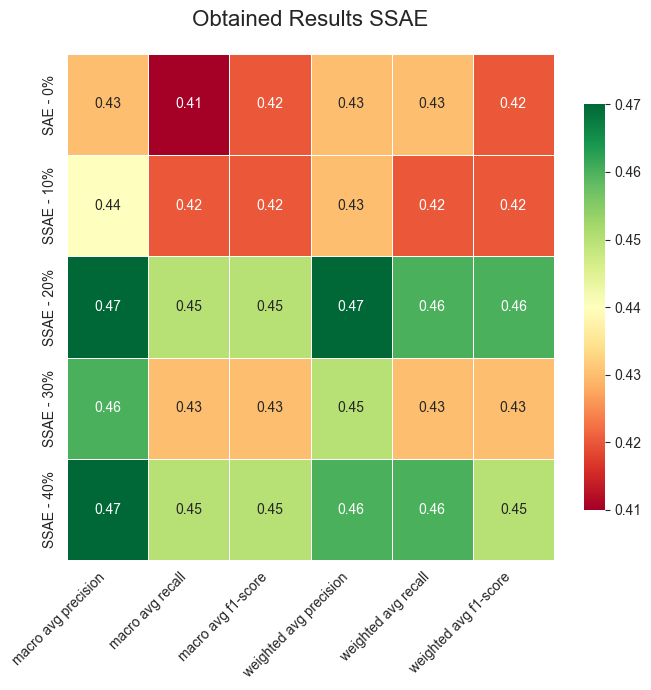

In [39]:
result_path_fs = os.path.join(result_path_fs, "results_heatmap")
try:
    os.makedirs(result_path_fs, exist_ok=True)
except:
    pass
plt.figure(figsize=(7, 7))
sns.heatmap(
    result_df[result_df.columns.values[:-1]],
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    yticklabels=result_df[result_df.columns.values[-1]],
)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

plt.title("Obtained Results SSAE", fontsize=16, pad=20)

plt.tight_layout()
plt.savefig(result_path_fs + f'/results_SSAE_alpha={alpha}.png')
plt.show()